In [1]:
import os
import numpy as np
import pandas as pd

#from pyjaspar import jaspardb
import pychromvar as pc

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

import time
import tqdm
#import tabix
#import pyBigWig
import pandas as pd
from matplotlib import pyplot as plt

import pickle
import sys
import os
import wandb

In [2]:
file_dir = os.path.abspath('')
save_dir = os.path.join(file_dir, 'train_output')
data_dir = os.path.join(file_dir, '..','data_preprocessing','generated_data')


ddsm_path = os.path.join(file_dir, '..', '..', 're_design', 'ddsm')
if ddsm_path not in sys.path:
    sys.path.append(ddsm_path)
    sys.path.append(os.path.join(ddsm_path,"external"))
    
train_utils_path = os.path.join(file_dir,'..','train_utils')
if train_utils_path not in sys.path:
    sys.path.append(train_utils_path)

In [3]:
from ddsm import (
    UnitStickBreakingTransform,
    diffusion_factory,
    gx_to_gv,
    Euler_Maruyama_sampler,
    diffusion_fast_flatdirichlet
)
# from selene_utils import *
from utils import (
    extract_motifs,
    compare_motif_list,
    kl_heatmap,
    generate_heatmap,
    generate_similarity_using_train,
    gc_content_ratio,
    min_edit_distance_between_sets,
    generate_kmer_frequencies,
    knn_distance_between_sets,
    distance_from_closest_in_second_set,
    plot_training_loss,
    plot_training_validation    
)

from utils_data import load_TF_data, SequenceDataset

from ddsm_tools import (
    Dense,
    ScoreNet,
    TrainDDSM
)

/root/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class ModelParameters:
    diffusion_weights_file = f'{data_dir}/steps400.cat4.time4.0.samples20000.pth'
    datafile = f'{data_dir}/tcre_seq_motif_cluster.csv'
    time_dependent_weights_file = f'{save_dir}/time_dependent_weights.pkl'
    seq_length = 200
    subset = None
    device = 'cuda'
    batch_size = 120
    num_workers = 8
    
    n_time_steps = 400
    speed_balanced = True

    ncat = 4

    lr = 5e-4

    num_epochs = 200
    log_step_show=1
    sample_epoch=10 
    save_epoch=10 
    num_sampling_to_compare_cells = 1000
    sample_bs = 100

config = ModelParameters()


torch.set_default_dtype(torch.float32)

loaded data


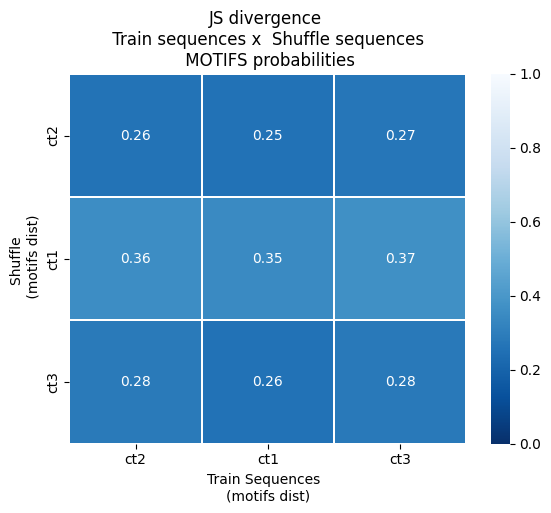

In [5]:
### initialize the dataloader ###
data = load_TF_data(
    data_path=config.datafile,
    seqlen=config.seq_length,
    limit_total_sequences=config.subset,
    num_sampling_to_compare_cells=config.num_sampling_to_compare_cells,
    to_save_file_name="cre_encode_data_motif_cluster",
    saved_file_name="cre_encode_data_motif_cluster.pkl",
    load_saved_data=True,
    start_label_number = 0,
)

cell_list = list(data["numeric_to_tag"].values())

motif_df = kl_heatmap(
    data['train_motifs_cell_specific'],
    data['train_motifs_cell_specific'],
    cell_list
)
generate_heatmap(motif_df, "Train", "Train", cell_list)
motif_df = kl_heatmap(
    data['test_motifs_cell_specific'],
    data['train_motifs_cell_specific'],
    cell_list
)
generate_heatmap(motif_df, "Test", "Train", cell_list)
motif_df = kl_heatmap(
    data['train_motifs_cell_specific'],
    data['shuffle_motifs_cell_specific'],
    cell_list
)
generate_heatmap(motif_df, "Train", "Shuffle", cell_list)

print("loaded data")

loaded weightseights 111


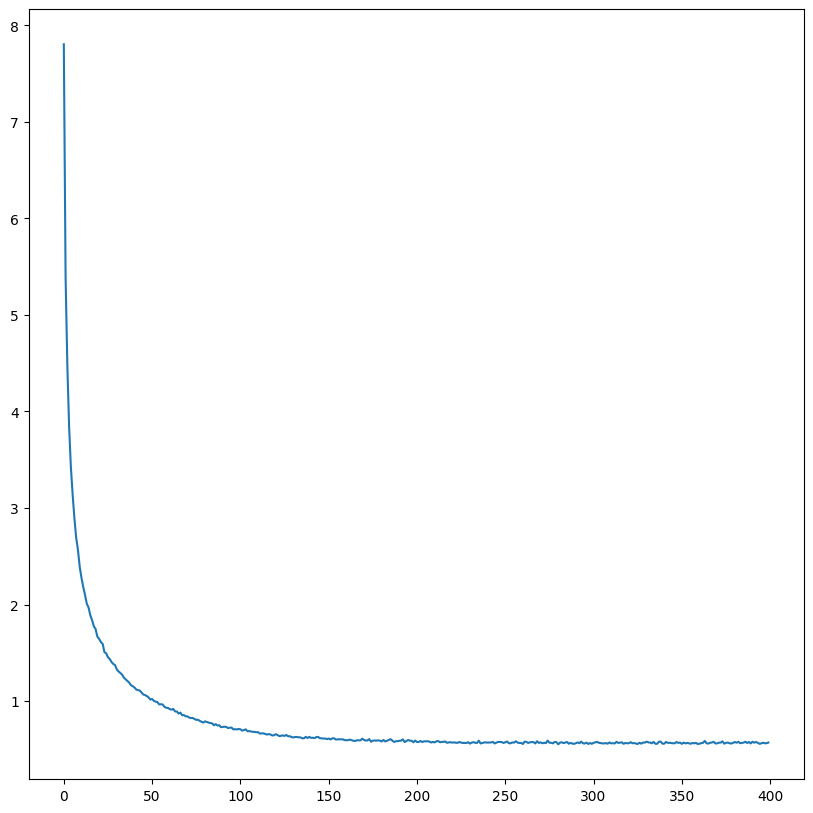

In [6]:
# TRAINING
sampler = Euler_Maruyama_sampler
trainer = TrainDDSM(config, data, sampler)
# return to zeroes from dna diffusion preprocessing
data["X_train"][data["X_train"] == -1] == 0
seq_dataset = SequenceDataset(seqs=data["X_train"], c=data["x_train_cell_type"], transform_dna=None, transform_ddsm = True)
data_loader = DataLoader(seq_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)

# weights and presampled noise
### LOAD WEIGHTS
time_dependent_weights = trainer.get_time_dependent_weights(config.time_dependent_weights_file, data_loader, load_saved_file=False)
    
#### TRAINING CODE
score_model = nn.DataParallel(ScoreNet(time_dependent_weights=torch.sqrt(time_dependent_weights)))
score_model = score_model.to(config.device)

optimizer = Adam(score_model.parameters(), lr=config.lr)

trainer.init_train(score_model, optimizer)

In [ ]:
train_kl, test_kl, shuffle_kl = 1, 1, 1
seq_similarity = 1
gc_ratio = 0
min_edit_distance, knn_distance, distance_from_closest = 100, 0, 0

KMER_LENGTH = 8
loss_values = []
all_seq_similarity = []
all_train_kl = []
all_test_kl = []
all_shuffle_kl = []

avg_loss = 0.
num_items = 0
min_kl_test = 1
for epoch in tqdm.tqdm(range(1, config.num_epochs + 1)):
    stime = time.time()
    avg_loss = 0.
    num_items = 0
    for xS in data_loader:
        x = xS[:, :, :4] # the promoter sequence
        s = xS[:, :, 4:5] # the average CAGE signal over the forward and reverse sequences

        avg_loss, num_items = trainer.ddsm_train_step(x, s, avg_loss, num_items)

    # validation
    if epoch % config.sample_epoch == 0:
        torch.set_default_dtype(torch.float32)
        allsamples = []
        print("sampling")
        synt_df, generated_sequences = trainer.create_sample()
        seq_similarity = generate_similarity_using_train(data["X_train"], config.seq_length)
        train_kl = compare_motif_list(synt_df, data["train_motifs"])
        test_kl = compare_motif_list(synt_df, data["test_motifs"])
        shuffle_kl = compare_motif_list(synt_df, data["shuffle_motifs"])
        print("Similarity", seq_similarity)
        print("KL_TRAIN", train_kl, "JS")
        print("KL_TEST", test_kl, "JS")
        print("KL_SHUFFLE", shuffle_kl, "JS")
        all_seq_similarity.append(seq_similarity)
        all_train_kl.append(train_kl)
        all_test_kl.append(test_kl)
        all_shuffle_kl.append(shuffle_kl)

        train_sequences = data["train_sequences"]
        gc_ratio = gc_content_ratio(train_sequences, generated_sequences)
        min_edit_distance = min_edit_distance_between_sets(generated_sequences, train_sequences)
        train_vectors, generated_vectors = generate_kmer_frequencies(train_sequences, generated_sequences, KMER_LENGTH)
        knn_distance = knn_distance_between_sets(generated_vectors, train_vectors)
        distance_from_closest = distance_from_closest_in_second_set(generated_vectors, train_vectors)
        print("Min_Edit", min_edit_distance)
        print("KNN_distance", knn_distance)
        print("Distance_endogenous", distance_from_closest)

    if test_kl < min_kl_test and epoch % config.save_epoch == 0:
        print("saving")
        checkpoint_dict = {
            "model": score_model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
        }
        torch.save(
            checkpoint_dict,
            f"checkpoints/epoch_{epoch}_label_guided.pt",
        )

In [ ]:
plot_training_loss(loss_values, save_dir)
validations = [all_train_kl, all_test_kl, all_shuffle_kl, all_seq_similarity]
labels = ["train JS divergence", "test JS divergence", "shuffle JS divergence", "train similarity"]
plot_training_validation(validations, labels, config.sample_epoch, save_dir)

print("training graphs saved")


In [ ]:
cell_num_list = data['cell_types']
cell_list = list(data["numeric_to_tag"].values())
nucleotides = ["A", "C", "G", "T"]
sample_bs = config.sample_bs
num_samples = round(config.num_sampling_to_compare_cells/sample_bs)
generated_celltype_motif = {}
seqlen = config.seq_length
# iterate over cell types
for cell_num in cell_num_list:
    cell_type = data['numeric_to_tag'][cell_num]
    print(f"Generating {config.num_sampling_to_compare_cells} samples for cell_type {cell_type}")
    final_sequences = []
    for n_a in range(num_samples):
        sampled_cell_types = np.array([cell_num] * sample_bs)
        sampled = np.repeat(sampled_cell_types[:, np.newaxis], seqlen, axis=1).reshape(sample_bs, seqlen, 1)
        classes = torch.from_numpy(sampled).float().to(config.device)

        samples = sampler(score_model,
                        (seqlen,4),
                        batch_size=sample_bs,
                        max_time=trainer.max_time,
                        min_time=trainer.min_time,
                        time_dilation=4,
                        time_dilation_start_time=1,
                        num_steps=400,
                        eps=1e-5,
                        device=config.device,
                        concat_input = classes)
        sampled_images = samples.clamp(0.0, 1.0)
        # iterate over last (clear) images
        for n_b, x in enumerate(sampled_images):
            # prepare for fasta and trasform from one-hot to nucletides
            seq_final = f">seq_test_{n_a}_{n_b}\n" + "".join(
                [nucleotides[s] for s in np.argmax(x.detach().cpu(), axis=1)]
            )
            final_sequences.append(seq_final)
        # extract motifs from generated sequences
    df_motifs_count_syn = extract_motifs(final_sequences)
    generated_celltype_motif[cell_type] = df_motifs_count_syn

In [ ]:
# Generate synthetic vs synthetic heatmap
motif_df = kl_heatmap(
    generated_celltype_motif,
    generated_celltype_motif,
    cell_list
)
generate_heatmap(motif_df, "Generated", "Generated", cell_list)

# Generate synthetic vs train heatmap
motif_df = kl_heatmap(
    generated_celltype_motif,
    data['train_motifs_cell_specific'],
    cell_list
)
generate_heatmap(motif_df, "Generated", "Train", cell_list)

print("Finished generating heatmaps")

# Explore

In [7]:
from ddsm import (
    GaussianFourierProjection,
    diffusion_factory, 
    diffusion_fast_flatdirichlet,
    gx_to_gv,
    gv_to_gx,
    UnitStickBreakingTransform,
    Euler_Maruyama_sampler
    )

In [8]:
time_dependent_weights.shape

torch.Size([400])

In [9]:
v_one, v_zero, v_one_loggrad, v_zero_loggrad, timepoints = trainer.v_one, trainer.v_zero, trainer.v_one_loggrad, trainer.v_zero_loggrad, trainer.timepoints

In [17]:
def diffusion_factory_with_tracking(
        x, time_indices, noise_factory_one, noise_factory_zero,
        noise_factory_one_loggrad, noise_factory_zero_loggrad,
        alpha=None, beta=None, device="cuda", return_v=False, eps=1e-5):
    """
    Generate multivariate Jacobi diffusion samples and scores by sampling from noise factory
    for k-1 Jacobi diffusion processes, recording each step.
    """
    # Initialize alpha and beta if they are not provided
    K = x.shape[-1]
    if alpha is None:
        alpha = torch.ones(K - 1)
    if beta is None:
        beta = torch.arange(K - 1, 0, -1, dtype=torch.float)

    noise_factory_size = noise_factory_one.shape[0]
    sb = UnitStickBreakingTransform()
    sample_indices = torch.randint(0, noise_factory_size, size=x.size()[:-1])
    tracked_samples = []

    for time_idx in time_indices:
        # Expand time index to appropriate shape for broadcasting
        time_ind_expanded = time_idx[(...,) + (None,) * (x.ndim - 2)].expand(x.shape[:-1])

        v_samples = noise_factory_zero[sample_indices, time_ind_expanded, :].to(device).float()
        v_samples_grad = noise_factory_zero_loggrad[sample_indices, time_ind_expanded, :].to(device).float()

        # Iterate over each channel in the last dimension
        for i in range(K - 1):
            inds = x[..., i] == 1
            if torch.any(inds):
                v_samples[..., i][inds] = noise_factory_one[sample_indices[inds], time_ind_expanded[inds], i].to(device).float()
                v_samples_grad[..., i][inds] = noise_factory_one_loggrad[sample_indices[inds], time_ind_expanded[inds], i].to(device).float()
            
        # Convert back from v space to x space, store the samples
        v_samples.requires_grad = True
        samples = sb(v_samples)
        tracked_samples.append(samples.detach().cpu().numpy())  # Store the samples at this time step

    if return_v:
        return v_samples, v_samples_grad, tracked_samples
    else:
        samples_grad = gv_to_gx(v_samples_grad, v_samples)
        samples_grad -= samples_grad.mean(-1, keepdims=True)
        return samples, samples_grad, np.array(tracked_samples)


In [18]:
tracked_samples = torch.FloatTensor(())
time_indices = torch.arange(config.n_time_steps).reshape((config.n_time_steps,1)) 


for idx, td in enumerate(data_loader):
    if idx < 2:
        samples, grads, tracked_samples_batch = diffusion_factory_with_tracking(
        td[:,:,:4],
        time_indices,
        v_one, v_zero, v_one_loggrad, v_zero_loggrad, trainer.alpha, trainer.beta
        )
        tracked_samples = torch.cat((tracked_samples, torch.FloatTensor(tracked_samples_batch)), 1)

In [29]:
nucleotides = ["A", "C", "G", "T"]
all_seq_similarity = []
all_train_kl = []
all_test_kl = []
all_shuffle_kl = []
all_gc = []
all_edit = []
all_knn = []
all_closest = []

KMER_LENGTH = 5

for x_train_step in tracked_samples:
    decoded_sequences = []
    for n_b, x in enumerate(x_train_step):
            # prepare for fasta and trasform from one-hot to nucletides
            seq_final = f">seq_test_{n_b}\n" + "".join(
                [nucleotides[s] for s in np.argmax(x.detach().cpu(), axis=1)]
            )
            decoded_sequences.append(seq_final)
        # extract motifs from generated sequences
    synt_df = extract_motifs(decoded_sequences)
    seq_similarity = generate_similarity_using_train(data["X_train"], config.seq_length)
    train_kl = compare_motif_list(synt_df, data["train_motifs"])
    test_kl = compare_motif_list(synt_df, data["test_motifs"])
    shuffle_kl = compare_motif_list(synt_df, data["shuffle_motifs"])


    train_sequences = data["train_sequences"]
    gc_ratio = gc_content_ratio(decoded_sequences, train_sequences)
    min_edit_distance = min_edit_distance_between_sets(decoded_sequences, train_sequences)
    train_vectors, generated_vectors = generate_kmer_frequencies(train_sequences, decoded_sequences, KMER_LENGTH)
    knn_distance = knn_distance_between_sets(generated_vectors, train_vectors)
    distance_from_closest = distance_from_closest_in_second_set(generated_vectors, train_vectors)

    all_seq_similarity.append(seq_similarity)
    all_train_kl.append(train_kl)
    all_test_kl.append(test_kl)
    all_shuffle_kl.append(shuffle_kl)
    all_gc.append(gc_ratio)
    all_edit.append(min_edit_distance)
    all_knn.append(knn_distance)
    all_closest.append(distance_from_closest)




Fraction of total variance explained by PCA components:  0.4063028288195005
Fraction of total variance explained by PCA components:  0.4063781798596431
Fraction of total variance explained by PCA components:  0.4064250324781524


KeyboardInterrupt: 

In [30]:
def plot_training_validation(values_list, y_labels, per_epoch):
    plt.figure()
    for idx, values in enumerate(values_list):
        X = list(range(0,len(values)*per_epoch,per_epoch))
        plt.plot(X, values, label=y_labels[idx])
    
    plt.title(f"Training process \n Validation stats every {per_epoch} epoch")
    plt.xlabel("epoch")
    plt.legend()
    plt.savefig(f"{save_dir}/validation_training.png")

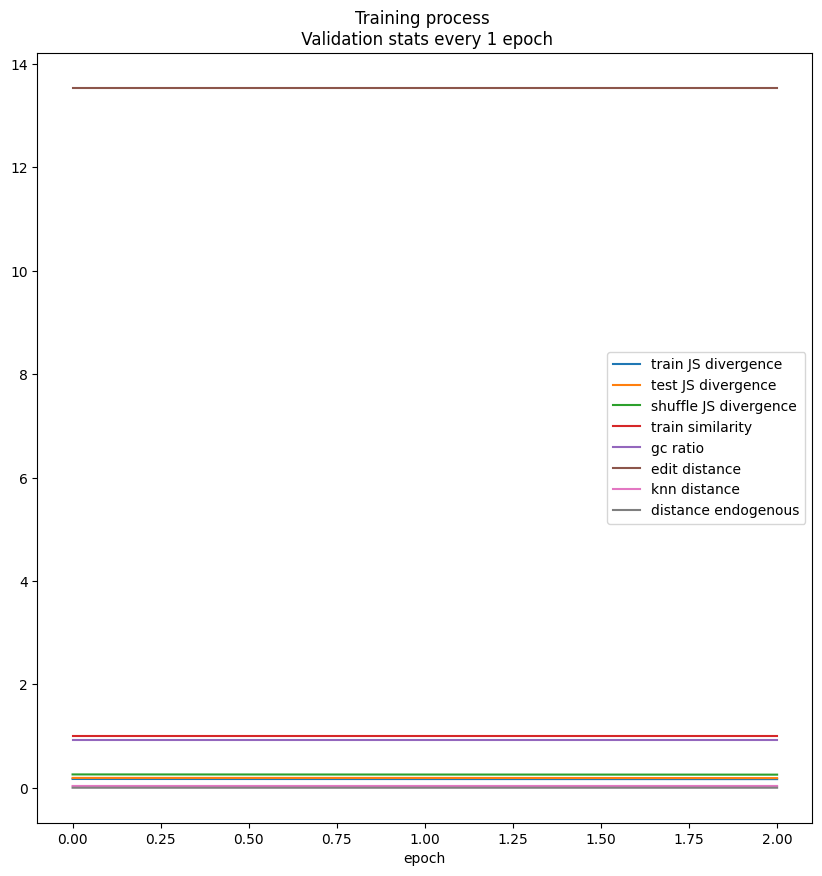

In [31]:
validations = [all_train_kl, all_test_kl, all_shuffle_kl, all_seq_similarity, all_gc, all_edit, all_knn, all_closest]
labels = ["train JS divergence", "test JS divergence", "shuffle JS divergence", "train similarity", "gc ratio", "edit distance", "knn distance", "distance endogenous"]
plot_training_validation(validations, labels, 1)